In [2]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from IPython.display import Image # 그림 삽입

In [3]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.1  Device: cuda


In [20]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
EPOCHS = 10

transform_train = transforms.Compose([
    #transforms.Resize(299),
    transforms.ToTensor()])

transform_test = transforms.Compose([
    #transforms.Resize(299),
    transforms.ToTensor()])

In [21]:
''' 3. FashionMNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                    train = True, 
                                    download = True,
                                    transform = transform_train) 

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                   train = False, # train = False
                                   transform = transform_test)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) 

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False) 

In [22]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) 
    # torch.Size([32, 1, 299, 299]): 32개의 배치, 흑백이미지(1), 299*299 크기를 갖는 픽셀 array.
    # torch.FloatTensor: 실수형태로 구성되어 있는 tensor.
    
    print('y_train:', y_train.size(), 'type:', y_train.type())
    # torch.Size([32]): 한 배치에 해당하는 정답 32개.
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


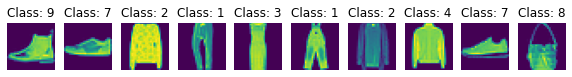

In [26]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

## Xception Flow

![1](../DL_img/Xception_Flow.png)

- [Entry Flow]
    - input: 229 x 229 x 3
    - 모든 convolutional layer 다음에는 batch normalization 을 사용한다
    - 2번 normal convolution (3x3) -> 필터의 갯수: 32 -> 64
    - Residual Network 가 합쳐진 Inception Module 3번: entry_flow_2_residual, entry_flow_3_residual, entry_flow_4_residual


- [Middle Flow]
    - 반복되는 단순한 모델: 필터의 개수와 width/height 는 바뀌지 않는다
    - ReLU -> Separable Conv -> Separable Conv 8번 반복하기


- [Exit Flow]
    - filter의 개수를 늘린다음 -> Maxpooling -> 2번 separable convolution -> Global Average Pooling -> Optional Fully-Connected -> Logistic Regression

In [27]:
''' depthwise separable convolution '''
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [28]:
''' 6. Xception 모델 구축하기 '''

class Xception(nn.Module):
    def __init__(self, input_channel, num_classes=10):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.entry_flow_1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.entry_flow_2 = nn.Sequential(
            depthwise_separable_conv(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            depthwise_separable_conv(128, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_2_residual = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)
        
        self.entry_flow_3 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            
            nn.ReLU(True),
            depthwise_separable_conv(256, 256, 3, 1),
            nn.BatchNorm2d(256),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_3_residual = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)
        
        self.entry_flow_4 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(256, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_4_residual = nn.Conv2d(256, 728, kernel_size=1, stride=2, padding=0)
        
        # Middle Flow
        self.middle_flow = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728)
        )
        
        # Exit Flow
        self.exit_flow_1 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.exit_flow_1_residual = nn.Conv2d(728, 1024, kernel_size=1, stride=2, padding=0)
        
        self.exit_flow_2 = nn.Sequential(
            depthwise_separable_conv(1024, 1536, 3, 1),
            nn.BatchNorm2d(1536),
            nn.ReLU(True),
            
            depthwise_separable_conv(1536, 2048, 3, 1),
            nn.BatchNorm2d(2048),
            nn.ReLU(True)
        )
        
        self.linear = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        entry_out1 = self.entry_flow_1(x)
        entry_out2 = self.entry_flow_2(entry_out1) + self.entry_flow_2_residual(entry_out1)
        entry_out3 = self.entry_flow_3(entry_out2) + self.entry_flow_3_residual(entry_out2)
        entry_out = self.entry_flow_4(entry_out3) + self.entry_flow_4_residual(entry_out3)
        
        middle_out = self.middle_flow(entry_out) + entry_out
        
        for i in range(7): # 한번 돌렸기 때문에 7번 더 돌리면 됨
            middle_out = self.middle_flow(middle_out) + middle_out

        exit_out1 = self.exit_flow_1(middle_out) + self.exit_flow_1_residual(middle_out)
        exit_out2 = self.exit_flow_2(exit_out1)

        exit_avg_pool = F.adaptive_avg_pool2d(exit_out2, (1, 1)) # Global Average Pooling                
        exit_avg_pool_flat = exit_avg_pool.view(exit_avg_pool.size(0), -1) # ???

        output = self.linear(exit_avg_pool_flat)
        
        return output

In [33]:
''' 7. Optimizer, Objective Function 설정하기 '''

# init 모듈 : weight, bias 등 초깃값으로 설정되는 요소에 대한 모듈
import torch.nn.init as init

def weight_init(m): # weight 초기화
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data) #He Initialization (앞서 ReLU 함수 적용했기 때문에)
        # init.kaiming_normal_(m.weight.data)

model = Xception(1).to(DEVICE)
model.apply(weight_init)

#Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # SGD (+momentum)

criterion = nn.CrossEntropyLoss()

print(model)

Xception(
  (entry_flow_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (entry_flow_2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): depthwise_separable_conv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
      (pointwise): Conv2d(128, 128, 

In [34]:
''' 8. Xception 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [35]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [36]:
''' 10. Xception 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
testloss = []
testaccuracy = []

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    
    testloss.append(test_loss)
    testaccuracy.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.921250
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 1.309975
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.746087
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.605381
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.736075
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.561539
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.630545
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.379232
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.392699
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.406023

[EPOCH: 1], 	Test Loss: 0.6670, 	Test Accuracy: 79.90 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.553722
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.414102
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.279457
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.570410
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.226458
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.306614
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.881880
T

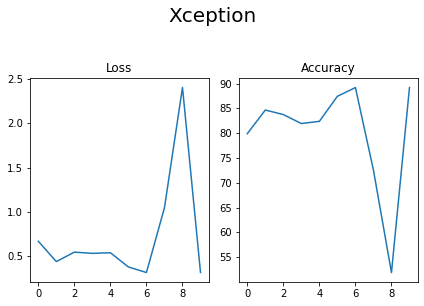

In [38]:
# 결과 시각화
plt.subplot(121)
plt.plot(testloss)
plt.title('Loss')

plt.subplot(122)
plt.plot(testaccuracy)
plt.title('Accuracy')

plt.suptitle('Xception',  position = (0.5, 1.0+0.05), fontsize = 20)

plt.tight_layout()
plt.show()